Exercise Sheet No. 13

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 19.07.2021, 8 am
>
> Tutor: Chen Zhou [chen.zhou@kit.edu](mailto:chen.zhou@kit.edu)  
> **Please ask questions in the forum and only contact the tutor for issues regarding the grading**

---

**Topic**: This exercise sheet will focus on deep Q learning, their implementation and training, as well as an application to molecule optimization.

The code of this exercise is modified from the [work](https://github.com/hmetni/mol_dqn_pytorch) of Houssam Metni who works in Prof. Pascal Friederich's group for internship. The code is a Pytorch implementation of MolDQN as described in [Optimization of Molecules via Deep Reinforcement Learning](https://www.nature.com/articles/s41598-019-47148-x) by Zhenpeng Zhou, Steven Kearnes, Li Li, Richard N. Zare and Patrick Riley.

# Very important

Please all participate in the lecture evaluation! It would be very good to hear the opinion of all of you, as we want this lecture to continuously improve. So thank you very much in advance for filling both evaluation forms!

Vorlesung: https://onlineumfrage.kit.edu/evasys/online.php?p=LCL7F

Übung: https://onlineumfrage.kit.edu/evasys/online.php?p=UMC7M

The links will be available from Monday, July 12th to Wednesday, July 21st.

In this exercise, we will look into reinforcement learning, or deep Q learning to be more specific, and work on its implementation with experience replay and target network. With these techniques, we will try to design molecules with properties that are looked for during drug screening.

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import utils
import hyp
from rdkit.Chem import QED
from utils import penalized_logp
from rdkit import Chem
from environment import Molecule

# Deep Q Learning (DQN)
## Q-learning vs DQN
Before discussing DQN, let's review some basic knowledge about Q-learning. As you may recall from the lecture (hopefully :)), the general idea of Q-learning is updating the "Q table" during training according to the equation below:
$$Q^{new}(s_t, a_t) = Q(s_t, a_t) + \alpha(r_t + \gamma max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t))$$
There are problems with Q-learning. For example, if we have many states and choices of actions, the number of $(s, a)$ combinations can easily grow exponentially that makes it impossible to handle with a table. Besides, Q-learning has difficulty dealing with continuous data and the way to represent state $s_t$ in machine readable format can be tricky. Therefore, DQN emerges as a more advanced option, which uses a network approximator to predict $Q(s, a)$ values instead of keeping records in Q table.
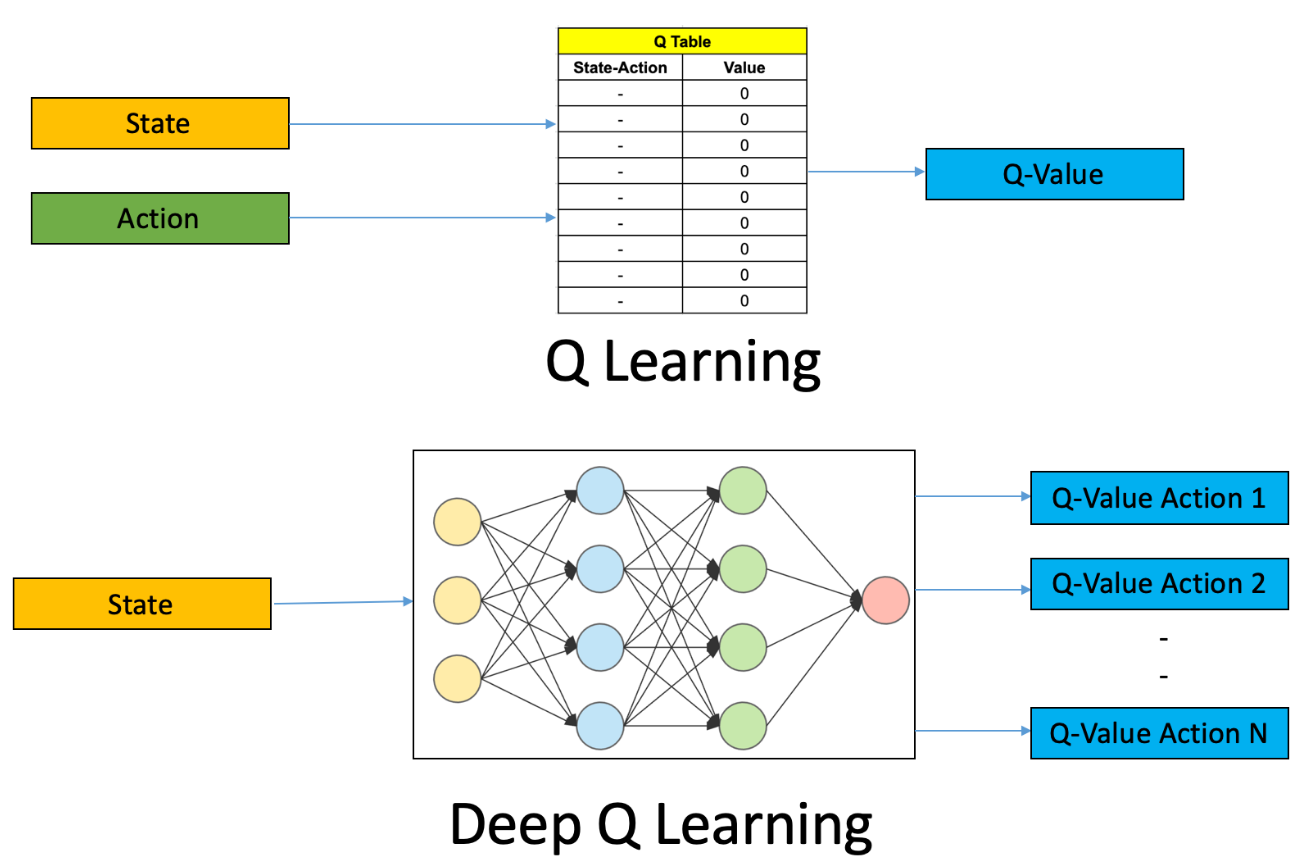
[image source](https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/)

## DQN Explanation
In DQN, Q values are predicted by neural networks (denoted as $Q(s, a; \theta)$ here). For each step $t$, we run a forward pass of the network to predict a set of $Q(s_t, a_t; \theta)$ values for all possible actions of the current state $s_t$. The agent selects one action to excute according to a predifined policy $\pi$, and reaches the next state $s_{t+1}$ to obatin reward $r_{t}$. The Q value $Q(s_{t+1}, a_{t+1}; \theta)$ of state $s_{t+1}$ is predicted and selected based on the same strategy. With the new information in hand, plus the Bellman equation, we are able to calculate the loss function and update the network through backpropagation:
$$LOSS(Q(s_t, a_t; \theta) - (r_{t} + \gamma Q(s_{t+1}, a_{t+1}; \theta)))$$
Below is the pseudocode of DQN algorithm from the paper [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
![dqn_algorithm](fig/dqn_algorithm.png)
### "Exploitation vs. exploration"
Notice that in the algorithm above, when selecting action, the policy (denote $\pi^\epsilon$ here) is to choose a random action with probability $\epsilon$, otherwise select the action that maximizes the Q value. This is the "Exploitation vs. exploration" situation we have encountered in the last exercise: we want to take the best action based on the knowledge we gained so far, but on the other hand, we also want to explore other possibilities and search for potentially even better options. The probability $\epsilon$ controls the trade-off between these two strategies.

### Off-policy
You may have heard that Q-learning and DQN are off-policy RL algorithm. This simply means the policy that the agent follows to select action is different from the policy that is optimized by the RL algorithem. In the case above, the agent follows $\pi^\epsilon$ that selects actions with randomness. While calculating the loss and updating networks, the policy ($\pi^*$) is followed that the action maximizing the Q value is always chosen.

### Experience Replay
You may have noticed that in the algorithm, the network is not updated per $(s_t, a_t, r_{t}, s_{t+1})$ set. Instead, the $(s_t, a_t, r_{t}, s_{t+1})$ "experiences" are stored in memory (the replay buffer) and sampled out randomly in minibach to update the network. This so called "Experience Replay" technique breaks the underlying correlation among data presented to neural network that may "confuse" the network. Therefore, experience replay helps to produce more stable results.

# MolDQN
In this exercise, we will implement the work by [Riley et al](https://www.nature.com/articles/s41598-019-47148-x). They developed a DQN algorithm named MolDQN to build molecule with properties desired in drug design. In MolDQN, the **environment** is the molecule, and each **state** is a Morgan fingerprint representation of the molecule. Morgan fingerprint is just an algorithm to generate fixed-length digit array encoding the molecular structure, it can be easily implemented with the rdkit library.
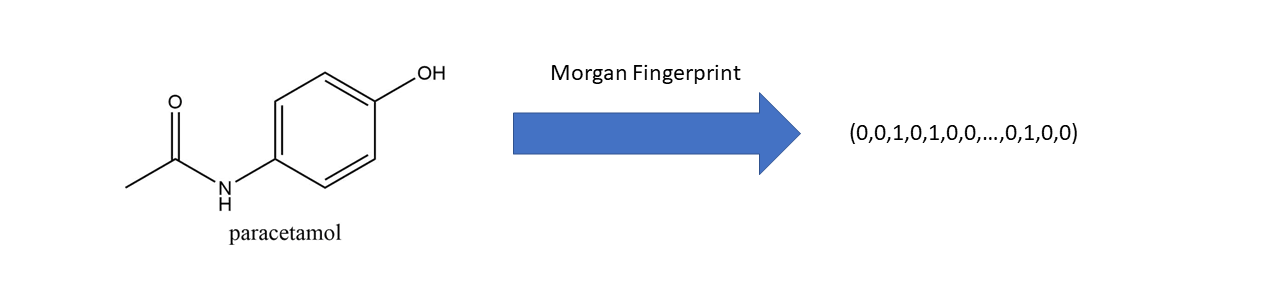
[image source](https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1)

The transition between two states is achieved by **actions** modifying the molecule. The modification step is formulated as a Markov decision process (MDP), including (1) atom addition, (2) bond addition, (3) bond removal and (4) no action. Please note that hydrogens are are considered implicitly, and all atom additions are defned as replacements of implicit hydrogens. Besides, only valid modification is considered. For example, directly adding an atom to a carbon with four non-hydrogen atoms connected is impossible. The modification is terminated and one episode is considered finished when reaching the maximum number of steps $T$. In this exercise, $T = 40$.
![actions.png](fig/actions.png)

The **reward** of each state is the [Quantitative Estimate of Druglikeness](https://www.nature.com/articles/nchem.1243) (QED) of the molecule at that state. QED is a score to measure the "beauty of drugs" (it's literally the name of the paper...) that range from 0 to 1, with 1 being the most drug-like. The rdkit library also provides a funtion to calculate this property. Another thing to keep in mind is that to ensure the final state is rewarded most heavily, we discount the value of the rewards at a state with time $t$ by discount factor $\gamma^{T-t}$. This is diferent from the usual way to define the discount factor.

In this exercise, all hyper parameters have already been set up for you and imported as "hyp".

In [2]:
REPLAY_BUFFER_CAPACITY = hyp.replay_buffer_size # size of the experience replay buffer
print("Replay buffer size: {}".format(REPLAY_BUFFER_CAPACITY))

# molecule to start with, we start from scratch so use None here
print("Molecule to start with: {}".format(hyp.start_molecule))

# we will build molecules with only C, N and O atoms
print("Atoms that can be added: {}".format(hyp.atom_types))

# maximum number of steps T
print("Molecule to start with: {}".format(hyp.max_steps_per_episode))

# learning rate
print("learning rate: {}".format(hyp.learning_rate))

# reward discount factor
print("Reward discount factor: {}".format(hyp.discount_factor))

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(DEVICE))

Replay buffer size: 1000000
Molecule to start with: None
Atoms that can be added: ['C', 'O', 'N']
Molecule to start with: 40
learning rate: 0.0001
Reward discount factor: 0.9
Using cpu device


For the purpose of autograding, please:

1. Set `do_training` = True while finishing this assignment.
2. Please submit your solution with `do_training` = False.

In [4]:
# Please submit your solution with do_training = False.
do_training = True

## Neural Network

Now enough talking, let's start with implementation of the neural network used for predicting Q values. A four-layer fully-connected network with hidden sizes of $[1024, 512, 128, 32]$ and ReLU activations is used as the network architecture. The network takes input with size `input_length` and generate output with size `ouput_length`.

Please recall that `nn.Linear` can be used for fc layers and `nn.ReLU` is the activation function.

In [5]:
class MolDQN(nn.Module):
    """Neural Networs for Q value prediction"""

    def __init__(self, input_length, output_length):
        super(MolDQN, self).__init__()
        
        self.fc1 = nn.Linear(input_length, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 128)
        self.fc4 = nn.Linear(self.fc3.out_features, 32)
        self.out = nn.Linear(self.fc4.out_features, output_length)
        
    def forward(self, x):
        from torch.nn import functional as F
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.out(x))

        return x

In [6]:
test_net = MolDQN(2048, 2)
assert len(test_net.state_dict()) == 10, 'check number of layers in your network'
# hidden test for number of parameters

## Environment

The Environment is already implemented for you and will be used later. The Environment is responsible for generating rewards, finding valid actions for current state and move to the next state.

In [7]:
class Environment(Molecule):
    """Monitor the state and return rewards, valid actions, flag of termination"""
    def __init__(self, discount_factor, **kwargs):
        super(Environment, self).__init__(**kwargs)
        self.discount_factor = discount_factor
        
    def _reward(self):
        molecule = Chem.MolFromSmiles(self._state)
        if molecule is None:
            return 0.0
        qed = QED.qed(molecule)
        return qed * self.discount_factor ** (self.max_steps - self.num_steps_taken)

## Experience Replay Buffer

Below is the implementation of replay buffer. It stores the `namedtuple` containing `action`, number of steps left `steps_left`, `reward` and flag `done` indicating termination for current state $s_t$, as well as set of `next_actions` for the new state $s_{t+1}$.

In [8]:
class ReplayBuffer(object):
    """Store set of actions and rewards"""
    def __init__(self, capacity):
        # set up namedtuple for replay buffer
        self.experience = collections.namedtuple('Experience',
                                                 field_names=['action', 'steps_left', 'reward', 'next_actions', 'done']
                                                )
        self.buffer = collections.deque(maxlen=capacity)
        
    def __len__(self):
        return len(self.buffer)
    
    def add(self, action_smiles, steps_left, reward, next_valid_actions, done):
        exp = self.experience(action_smiles, steps_left, reward, next_valid_actions, float(done))
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        exp = np.asarray([self.buffer[idx] for idx in indices], dtype=object)
        return exp[:,0].astype('str'), exp[:,1].astype('int'), exp[:,2].astype('float32'), \
               exp[:,3], exp[:,4].astype('float32')

## Deep Q Network Agent

For the next step, let's implement the agent `DeepQAgent` for DQN. Please read carefully the comments below and finish the `get_action` method as well as `loss` method.

1. For `get_action` method, the agent takes `valid_action_fps` and `epsilon` as input. `valid_action_fps` is the set of fingerprints that represent each action, and is uesd as input for `self.dqn` to predict Q values for each action. Please note that the order of action list matches the order of `valid_action_fps` (you will see this later in `train` function).

2. For `loss`, please finish the calculation of the LOSS function:

$$LOSS = (Q(s_t, a_t) - (r_t + \gamma max_{a'}Q(s_{t+1}, a')))$$

For Loss function, we use the Mean Squared Error Loss here (`nn.MSELoss()`). $Q(s_t, a_t)$, $max_{a'}Q(s_{t+1}, a')$ are represented as `q_states` and `q_next_states` accordingly.

In [21]:
class DeepQAgent(object):
    """
    DQN agent
    
    Responsible for selecting action and update parameters of MolDQN network
    """
    def __init__(self, input_length, output_length):
        self.dqn = MolDQN(input_length, output_length).to(DEVICE)
        self.buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)
        self.optimizer = Adam(self.dqn.parameters(), lr=hyp.learning_rate)
        
    def get_action(self, valid_action_fps, epsilon):
        """
        choose action based on ε-greedy policy
        
        Args:
            valid_action_fps (numpy.ndarray): set of fingerprints for valid actions, used as input of self.dqn
                                             ([action1_fingerprints], [action2_fingerprints], ...)
            epsilon (float): probablity of select action randomly.
            
        Returns:
            idx (int): index of selected action. Note the order of action list matches the order of valid_action_fps
        """
        
        if np.random.uniform() < epsilon:
            idx = None
            
            # select an action index randomly
            idx = np.random.randint(0, len(valid_action_fps))
        else:
            idx = None
            q_values = self.dqn.forward(valid_action_fps.to(DEVICE)).cpu()
            
            # select the action with largest Q value
            idx = np.argmax(q_values.detach())
        
        return idx
    
    def loss(self, q_states, q_next_states, gamma, rewards):
        """
        Calculate the mean square error
        
        Args:
            q_states (torch.Tensor): q value predictions for states at time t
            q_next_states (torch.Tensor): masked q value predictions for states at time t+1
            gamma (float): discount factor
            rewards (torch.Tensor): rewards for states t
            
        Returns:
            q_loss (torch.Tensor): loss values
        """
        
        # please implement the calculation of q_loss
        q_loss = None
        # YOUR CODE HERE
        criterion = nn.MSELoss()
        # q_loss = q_states - (rewards + gamma * np.argmax(q_next_states))
        print(f"Validation: {torch.max(q_next_states) == q_next_states}")
        q_loss = criterion(q_states, rewards + gamma * torch.max(q_next_states))
        q_loss_alt = criterion(q_states, rewards + gamma * q_next_states)
        print(f"Validation 2: {torch.allclose([q_loss, q_loss_alt])}")
        
        return q_loss
    
        """
        loss = torch.nn.MSELoss()
        q_loss = loss(q_states,rewards+gamma* q_next_states.max())
        """
    
    
    def update_parameters(self, batch_size, gamma):
        """
        update parameters in MolDQN through backpropagation.
        
        Args:
            batch_size (int): number of examples in minibach for training the network.
            gamma (float): discount factor.
            
        Returns:
            q_loss (float): loss value
        """
        # update target network

        # sample batch of transitions
        actions, steps_left, rewards, next_actions, dones = self.buffer.sample(batch_size)
        
        # generate fingerprint for MolDQN and predict the q value of current state
        q_states = torch.zeros(batch_size, 1, requires_grad=False)
        for i in range(0, batch_size):
            fp = utils.get_fingerprint(actions[i], hyp.fingerprint_length, hyp.fingerprint_radius)
            fp = np.append(fp, steps_left[i])
            # q value prediction
            q_states[i] = self.dqn.forward(torch.FloatTensor(fp).to(DEVICE))
        
        # generate fingerprint for MolDQN and predict q values for all valid actions of the next state
        q_next_states = torch.zeros(batch_size, 1, requires_grad=False)
        for i in range(0, batch_size):
            next_fps = []
            for j in range(0, len(next_actions[i])):
                fp = utils.get_fingerprint(next_actions[i][j], hyp.fingerprint_length, hyp.fingerprint_radius)
                next_fps.append(np.append(fp, steps_left[i]-1))
            # set of q values prediction
            q_next_states[i] = torch.max(self.dqn.forward(torch.FloatTensor(next_fps).to(DEVICE)))
        
        q_states = q_states.to(DEVICE)
        q_next_states = q_next_states.to(DEVICE)
        rewards = torch.FloatTensor(rewards).reshape(q_next_states.shape).to(DEVICE)
        dones = torch.FloatTensor(dones).reshape(q_next_states.shape).to(DEVICE)
        
        # If the step is the terminate step (t = max_steps_per_episode)
        ## the future reward Q value should be 0
        q_next_states_masked = (1 - dones) * q_next_states
        
        # compute the loss
        q_loss = self.loss(q_states, q_next_states_masked, gamma, rewards)
        
        # backpropagate
        self.optimizer.zero_grad()
        q_loss.backward()
        self.optimizer.step()
        
        return q_loss

In [22]:
# test the get_action method

test_agent = DeepQAgent(2048, 1)
initial_smiles = 'CCCCCCCC(C(C)C)CCC'

environment = Environment(
        discount_factor=hyp.discount_factor,
        atom_types=set(hyp.atom_types),
        init_mol=initial_smiles,
        allow_removal=hyp.allow_removal,
        allow_no_modification=hyp.allow_no_modification,
        allow_bonds_between_rings=hyp.allow_bonds_between_rings,
        allowed_ring_sizes=set(hyp.allowed_ring_sizes),
        max_steps=hyp.max_steps_per_episode,
    )
environment.initialize()

actions = list(environment.get_valid_actions())
fps = np.zeros((len(actions), 2048))
for i in range(len(fps)):
    fps[i] = utils.get_fingerprint(actions[i], 2048, hyp.fingerprint_radius)
fps = torch.FloatTensor(fps)

idx_predict = []
for i in range(10):
    idx_predict.append(test_agent.get_action(fps, 0.0))
    
idx_random = []
for i in range(10):
    idx_random.append(test_agent.get_action(fps, 1.0))

assert all(e == idx_predict[0] for e in idx_predict) , \
"check the get_action method, it should give the same output with no randomness"
assert not all(e == idx_random[0] for e in idx_random), \
"check the get_action method, it should give different outputs when choosing randomly"

# hidden test for self.dqn use in get_action

In [23]:
# test the loss method
test_agent = DeepQAgent(2048, 1)
q_0 = torch.rand(32, 1, requires_grad=False)
q_1 = torch.rand(32, 1, requires_grad=False)
gamma = 0.75
rewards = torch.rand(32, 1, requires_grad=False)
q_loss = test_agent.loss(q_0, q_1, gamma, rewards)
assert isinstance(q_loss, torch.Tensor), \
"The return value must be a torch.Tensor"
assert q_loss.requires_grad == False, \
"Please check your loss calculation, q values should not require gradient"
# hidden test for loss value check

Validation: tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


TypeError: allclose(): argument 'input' (position 1) must be Tensor, not list

## Fingerprint Generation

Now before we move to training, please implement the `generate_fingerprint` function, which takes as inputs a list of actions (SMILES codes), and the number of steps left. It returns a numpy array contains the corresponding fingerprints.

You will need the `utils.get_fingerprint` function to generate fingerprints. `utils.get_fingerprint` takes 3 inputs:
1. `smiles`: the SMILES code for each action.
2. `fingerprint_length`: hyper parameter `hyp.fingerprint_length`
3. `fingerprint_radius`: hyper parameter `hyp.fingerprint_radius`

Note that the shape of the return value `valid_action_fps` is already set up for you, which is `(len(valid_actions), hyp.fingerprint_length+1)`. For each fingerprint, the last element is always the `steps_left`.

In [29]:
def generate_fingerprint(actions, steps_left):
    """
    Generate fingerprint for set of actions
    
    Args:
        actions (list): list of actions (SMILES string).
        steps_left (int): number of steps left
        
    Returns:
        valid_action_fps (numpy.ndarray): array of fingerprints
    """
    
    valid_action_fps = np.zeros((len(actions), hyp.fingerprint_length+1))
    
    # YOUR CODE HERE
    for idx, action in enumerate(actions):
        valid_action_fps[idx, :-1] = utils.get_fingerprint(action, hyp.fingerprint_length, hyp.fingerprint_radius)
        valid_action_fps[idx, -1] = steps_left
    
    return valid_action_fps

In [30]:
# test the generate_fingerprint function

test_agent = DeepQAgent(2049, 1)
initial_smiles = 'CCCCCCCC(C(C)C)CCC'

environment = Environment(
        discount_factor=hyp.discount_factor,
        atom_types=set(hyp.atom_types),
        init_mol=initial_smiles,
        allow_removal=hyp.allow_removal,
        allow_no_modification=hyp.allow_no_modification,
        allow_bonds_between_rings=hyp.allow_bonds_between_rings,
        allowed_ring_sizes=set(hyp.allowed_ring_sizes),
        max_steps=hyp.max_steps_per_episode,
    )
environment.initialize()

actions = list(environment.get_valid_actions())

fps = generate_fingerprint(actions, 10)

assert fps.shape == (180, 2049), \
"The shape of output is NOT correct, please check if you include steps_left in fingerprint"
assert fps[0][-1] == 10, "The steps_left should be the last element of fingerprint"

## Training

Now, with everything we have seen and implemented so far, let's put them together in `train()` function and have a try!

In [31]:
def train(agent, iterations=500000, batch_size=128, max_episodes = 3000, do_training=False):
    """
    The training function for both DQN and Double Q network
    
    Args:
        agent (object): DeepQAgent or DoubleQAgent agent.
        iterations (int): number of training iterations.
        batch_size (int): size of minibach used to update neural network.
        do_training (bool): flag indicate do training or not.
        
    Returns:
        episodes_list (list): list of episodes of training.
        smiles_list (list): list of all SMILES generated during training
        rewards_list (list): list of values of rewards as defined in environment
        losses_list (list): list of training losses.
    """
    
    episodes = 0  # number of episodes, get updated as training happens
    update_interval = 20  # how often the agent parameters get updated

    # initialize lists
    episodes_list, smiles_list, rewards_list, losses_list = [], [], [], []
    if not do_training:
        return episodes_list, smiles_list, rewards_list, losses_list

    # train on cuda if available
    device = torch.device(DEVICE)

    # set up the environment
    ## use hyper parameters metioned earlier
    environment = Environment(
        discount_factor=hyp.discount_factor,
        atom_types=set(hyp.atom_types),
        init_mol=hyp.start_molecule,
        allow_removal=hyp.allow_removal,
        allow_no_modification=hyp.allow_no_modification,
        allow_bonds_between_rings=hyp.allow_bonds_between_rings,
        allowed_ring_sizes=set(hyp.allowed_ring_sizes),
        max_steps=hyp.max_steps_per_episode,
    )

    # initialize environment
    environment.initialize()
    
    # start training with ε = 1, i.e. select action randomly
    eps_threshold = 1.0
    batch_losses = []
    
    for it in range(0, iterations):
        steps_left = hyp.max_steps_per_episode - environment.num_steps_taken
        # valid_actions are set of SMILES of molecule resulting from the action 
        valid_actions = list(environment.get_valid_actions())
        
        # generate correspond fingureprint of the SMILES
        # combine figureprint with steps_left to generate input features for DQN
        valid_action_fps = generate_fingerprint(valid_actions, steps_left)
        
        # note that the order of "valid_action_fps" matches the order of "valid_actions"
        valid_action_fps = torch.FloatTensor(valid_action_fps)
        
        # choose action based on ε-greedy policy
        action_idx = agent.get_action(valid_action_fps, eps_threshold)
        action_fp = valid_action_fps[action_idx]
        action_smiles = valid_actions[action_idx]
        
        # take a step forward in environment
        _, reward, done = environment.step(action_smiles)
        next_valid_actions = list(environment.get_valid_actions())
        
        # store (action, step, reward, next_actions, done) as namedtuple into experience buffer
        # for memory efficiency, action and next_actions are stored as smiles string instead of fingureprints
        agent.buffer.add(action_smiles, steps_left, reward, next_valid_actions, done)
        
        # update paremeters for deep Q networks
        if it % update_interval == 0 and len(agent.buffer) >= batch_size:
            q_loss = agent.update_parameters(batch_size, hyp.gamma)
            q_loss = q_loss.item()
            batch_losses.append(q_loss)
        
        # reach the max step, done for an episode
        if done:
            if episodes != 0 and len(batch_losses) != 0:
                # add episode number to episodes_list
                episodes_list.append(episodes)
                print(
                    "SMILES generated in episode {} is {}".format(
                        episodes, action_smiles
                    )
                )
                # add smiles of final step to SMILES_list
                smiles_list.append(action_smiles)
                print(
                    "reward of final molecule at episode {} is {}".format(
                        episodes, reward
                    )
                )
                # update rewards list
                rewards_list.append(reward)
                print(
                    "mean loss in episode {} is {}".format(
                        episodes, np.array(batch_losses).mean()
                    )
                )
                # update losses list
                losses_list.append(np.array(batch_losses).mean())
                print("\n")
            
            episodes += 1
            if episodes > max_episodes: break

            # annealed ε from 1 to 0.01
            eps_threshold *= 0.99907
            
            # re-initialize the environment for next eposide
            batch_losses = []
            environment.initialize()
        
    return episodes_list, smiles_list, rewards_list, losses_list

Please note that the training takes very long time (5 to 6 hours on CPU, or 2 hours on GPU cluster) to complete (more than 100K iterations for 3k episodes). So here we will only try $500$ iterations (about $10$ episodes). The infomation of fully trained models will be posed at the end of this exercise. You can also try the entire training process by modifying the code below to:

`episodes_dqn, smiles_dqn, rewards_dqn, losses_dqn = train(agent, do_training=do_training)`

If you decide to train it for longer time, please do it in another notebook :)

In [32]:
agent = DeepQAgent(hyp.fingerprint_length+1, 1)
episodes_dqn, smiles_dqn, rewards_dqn, losses_dqn = train(agent, iterations=500, do_training=do_training)

SMILES generated in episode 3 is CN(N)C12OC(=O)OC1=NC(O)=C(ON)OC2=O
reward of final molecule at episode 3 is 0.2928893052602853
mean loss in episode 3 is 0.004712681286036968


SMILES generated in episode 4 is CC1=NC(O)N=C(N=C(O)N=O)C1=CN=CNN
reward of final molecule at episode 4 is 0.1662282777463702
mean loss in episode 4 is 0.00866149552166462


SMILES generated in episode 5 is N=NC1(NO)NC2(O)C(=C=COO)N1C2=NO
reward of final molecule at episode 5 is 0.07847756914040807
mean loss in episode 5 is 0.008205367252230644


SMILES generated in episode 6 is C#CC1(C)CC(OC)=C2ON=C(OO)ON21
reward of final molecule at episode 6 is 0.40120925456063067
mean loss in episode 6 is 0.006550436606630683


SMILES generated in episode 7 is CC=NC1(CC2=NOC3CN23)OO1
reward of final molecule at episode 7 is 0.3525928480591275
mean loss in episode 7 is 0.009109476115554571


SMILES generated in episode 8 is C=NC1=Cc2nn(C3(ON=C=NO)ON(OC#CNN)OC3=O)nc2OC1O
reward of final molecule at episode 8 is 0.098785932628

In [33]:
def plot_QED(episodes, rewards):
    fig = plt.figure()
    plt.plot(episodes, rewards)
    plt.xlabel('Episodes')
    plt.ylabel('QED values')
    plt.ylim([0.0, 1.0])
    plt.show()

Now let's plot the results. You may notice that the model seems to learn nothing after training. This is due to the annealing of $\epsilon$ (the probablity of acting randomly). We start with $\epsilon = 1.0$ and after each eposide, we updated $\epsilon$ with $\epsilon = \epsilon \times 0.99907$. Thus, after around $10$ episodes, the $\epsilon$ is still as large as $0.99$, and our agent still choose actions randomly at most time. This will change when we train the model with sufficient eposides, which we will see later.

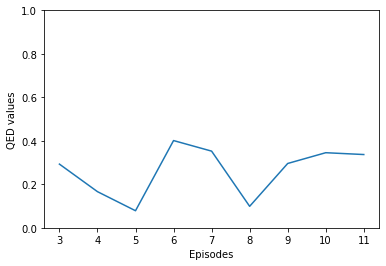

In [34]:
plot_QED(episodes_dqn, rewards_dqn)

## Double Q Network Agent

You may also learned from the lecture that there's another way to improve the performance of DQN, which is to keep an additional network named as "Target network" $Q(s, a; \theta')$. $Q(s, a; \theta')$ is only accessed when updating parameters of the "Primary network" ($Q(s, a; \theta)$), and is used to predict target value $y_{target}$ for Loss function:
$$y_{target} = r_t + \gamma max_{a'}Q(s_{t+1}, a'; \theta')$$
And the Loss function becomes:
$$LOSS(Q(s_t, a_t; \theta) - (r_t + \gamma max_{a'}Q(s_{t+1}, a'; \theta')))$$

Please note that the parameters of $Q(s, a; \theta')$ is not updated through backpropagation. Instead, we slowly copy the parameters of $Q(s, a; \theta)$ to the target network $Q(s, a; \theta')$ ($\gamma$ is usually set to be $0.01$):
$$\theta' = (1 - \gamma) \theta' + \gamma \theta$$

Below is the algorithm of double Q learning. Since $\theta'$ is slowly copied from $\theta$, it can be viewed as containing more "history" information of the dataset.
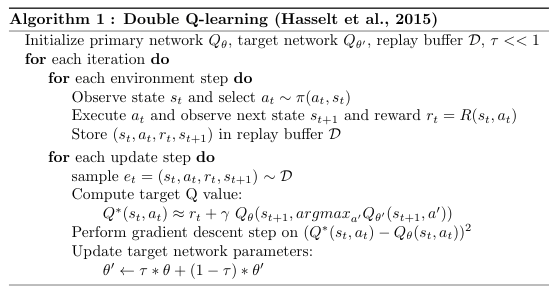

There are several advantages of using two networks:
1. The state $s_t$ and $s_{t+1}$ can be very similar, and it may be difficult for our network to distinguish them. Therefore, if we have only one network, when updating parameters to make $Q(s_t, a_t)$ prediction more accurate, we may also alter the value produced for $Q(s_{t+1}, a_{t+1})$. This can cause unstability during training. And having a target network contains more "history" information can help distinguish two close states.
2. Another problem of DQN is that it tends to overestimate the Q values for states, because we always take the $max_aQ(s, a)$ as our choice. This behavior can also lead to unstable training and low quality policy. Having the target network can solve this problem by letting each of the networks estimate parameters for the other one.

For more information about double Q learning, please read the paper [here](https://arxiv.org/abs/1509.06461).

Now, please implement the `get_action`, `loss` and `update_target_network` method of `DoubleQAgent`.

1. The `get_action` method should be the same as `DeepQAgent`.

2. For `loss` method, this time, we will use the Huber loss as loss function:
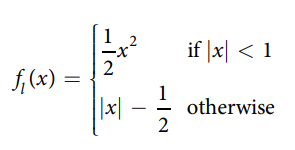

Where
$$ x = (Q(s_t, a_t; \theta) - (r_t + \gamma max_{a'}Q(s_{t+1}, a'; \theta')))$$

Please use `torch.where` for condition operation (do not use `if-else`). You may refer to the [documentation](https://pytorch.org/docs/stable/generated/torch.where.html).


3. For `update_target_network` method, please update the parameters $\theta'$ of `self.target_dqn` through:
$$\theta' = (1 - \gamma) \theta' + \gamma \theta$$

In `update_target_network`, the way to extract parameters from `self.dqn` and `self.target_dqn` is already implemented for you. You may use `.data` property of parameters to access parameter data, and use `.mul_()` and `.add_()` for inplace multiplication and addition. $\gamma$ is given as `factor` here.

In [56]:
class DoubleQAgent(object):
    """
    Double Q agent
    
    Responsible for selecting action and update parameters of MolDQN network
    """
    def __init__(self, input_length, output_length):
        # initilize two networks
        self.dqn, self.target_dqn = (
            MolDQN(input_length, output_length).to(DEVICE),
            MolDQN(input_length, output_length).to(DEVICE),
        )
        # fix the paremeters of target network
        for p in self.target_dqn.parameters():
            p.requires_grad = False
        self.buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)
        self.optimizer = Adam(self.dqn.parameters(), lr=hyp.learning_rate)

    def get_action(self, valid_action_fps, epsilon):
        """
        choose action based on ε-greedy policy
        
        Args:
            valid_action_fps (numpy.ndarray): set of fingerprints for valid actions, used as input of self.dqn
                                             ([action1_fingerprints], [action2_fingerprints], ...)
            epsilon (float): probablity of select action randomly.
            
        Returns:
            idx (int): index of selected action. Note the order of action list matches the order of valid_action_fps
        """
        
        if np.random.uniform() < epsilon:
            idx = None
            
            # select an action index randomly
            # YOUR CODE HERE
            idx = np.random.randint(0, len(valid_action_fps))
        else:
            idx = None
            q_values = self.dqn.forward(valid_action_fps.to(DEVICE)).cpu()
            
            # select the action with largest Q value
            # YOUR CODE HERE
            idx = np.argmax(q_values.detach())
        
        return idx
    
    def loss(self, q_states, q_next_states, gamma, rewards):
        """
        Calculate the mean square error
        
        Args:
            q_states (torch.Tensor): q value predictions for states at time t
            q_next_states (torch.Tensor): masked q value predictions for states at time t+1
            gamma (float): discount factor
            rewards (torch.Tensor): rewards for states t
            
        Returns:
            q_loss (torch.Tensor): loss values
        """
        
        # please implement the calculation of q_loss
        q_loss = None
        # YOUR CODE HERE
        loss_x = q_states - (rewards + gamma * torch.max(q_next_states))
        q_loss = torch.where(torch.abs(loss_x) < 1, (1/2)*torch.pow(loss_x, 2), torch.abs(loss_x) - (1/2))
        
        return q_loss.mean()
    
    def update_target_network(self, factor):
        """update target network by copying parameters from primary network"""
        
        with torch.no_grad():
            assert factor > 0
            for p, p_targ in zip(self.dqn.parameters(), self.target_dqn.parameters()):
                # p: parameter of self.dqn
                # p_targ: parameter of self.target_dqn
                # use .data to access parameter data
                # use .mul_ and .add_ for multiplication and addition
                # please do not forget the factor
                
                # YOUR CODE HERE
                p_targ.data.mul_(1-factor).add_(p.data *factor)
                # p_targ.data = (1-factor)*p_targ.data + factor*p.data

    def update_parameters(self, batch_size, gamma):
        """
        update parameters of self.dqn through backpropagation.
        update parameters of self.target_dqn by copying from self.dqn
        
        Args:
            batch_size (int): number of examples in minibach for training the network.
            gamma (float): discount factor.
            
        Returns:
            q_loss (float): loss value
        """
        
        # update target network

        # sample batch of transitions
        actions, steps_left, rewards, next_actions, dones = self.buffer.sample(batch_size)
        
        q_states = torch.zeros(batch_size, 1, requires_grad=False)
        for i in range(0, batch_size):
            fp = utils.get_fingerprint(actions[i], hyp.fingerprint_length, hyp.fingerprint_radius)
            fp = np.append(fp, steps_left[i])
            q_states[i] = self.dqn.forward(torch.FloatTensor(fp).to(DEVICE))
        
        q_next_states = torch.zeros(batch_size, 1, requires_grad=False)
        for i in range(0, batch_size):
            next_fps = []
            for j in range(0, len(next_actions[i])):
                fp = utils.get_fingerprint(next_actions[i][j], hyp.fingerprint_length, hyp.fingerprint_radius)
                next_fps.append(np.append(fp, steps_left[i]-1))
            next_fps = torch.FloatTensor(next_fps).to(DEVICE)
            # Please note that the target network is used to predict Q values here
            q_next_states[i] = torch.max(self.target_dqn.forward(next_fps))
            
        q_states = q_states.to(DEVICE)
        q_next_states = q_next_states.to(DEVICE)
        rewards = torch.FloatTensor(rewards).reshape(q_next_states.shape).to(DEVICE)
        dones = torch.FloatTensor(dones).reshape(q_next_states.shape).to(DEVICE)
        
        # If the step is the terminate step (t = max_steps_per_episode)
        ## the future reward Q value should be 0
        q_next_states_masked = (1 - dones) * q_next_states
        
        # compute the loss
        q_loss = self.loss(q_states, q_next_states_masked, gamma, rewards)

        # backpropagate
        self.optimizer.zero_grad()
        q_loss.backward()
        self.optimizer.step()
        
        # update target network
        self.update_target_network(0.01)

        return q_loss

In [57]:
# test the loss method
test_agent = DoubleQAgent(2048, 1)
q_0 = torch.rand(32, 1, requires_grad=False)
q_1 = torch.rand(32, 1, requires_grad=False)
gamma = 0.75
rewards = torch.rand(32, 1, requires_grad=False)
q_loss = test_agent.loss(q_0, q_1, gamma, rewards)
assert isinstance(q_loss, torch.Tensor), \
"The return value must be a torch.Tensor"
assert q_loss.requires_grad == False, \
"Please check your loss calculation, q values should not require gradient"
# hidden test for loss value check

Let's try to train the double Q network. You will notice that due to the limited number of iterations, the results would look close to the DQN before. You are also welcome to train it for longer time, but please do it in another notebook :)

In [58]:
agent = DoubleQAgent(hyp.fingerprint_length+1, 1)
episodes_double, smiles_double, rewards_double, losses_double = train(agent, iterations=500, do_training=do_training)

SMILES generated in episode 3 is C=COC1(C=C=N)CC(OC(C)=N)=C=C(On2n(C)n2C)C1(O)N=C
reward of final molecule at episode 3 is 0.286774619615558
mean loss in episode 3 is 0.0027772029861807823


SMILES generated in episode 4 is C=C1C(C2N=NO2)=NC12C13NOC(=CO1)C2(ONN)O3
reward of final molecule at episode 4 is 0.4261597847151218
mean loss in episode 4 is 0.0028662056429311633


SMILES generated in episode 5 is CC(=C=CN)C1(ON=N)NN(N=CO)C(=C=CN)O1
reward of final molecule at episode 5 is 0.1560963167447591
mean loss in episode 5 is 0.002794001018628478


SMILES generated in episode 6 is C=NC1(N=NON)OC2(OC2=NN2CO2)C1(NC)ON=NN
reward of final molecule at episode 6 is 0.11928527993996692
mean loss in episode 6 is 0.0024756380589678884


SMILES generated in episode 7 is N=NNC1OON(C=C(O)N(OO)N(N)O)N1N
reward of final molecule at episode 7 is 0.08851690026681859
mean loss in episode 7 is 0.0020749028772115707


SMILES generated in episode 8 is COCCON=C(C)OC(ON(N(C)C)C(O)(O)N=O)=C(N)O
reward of final

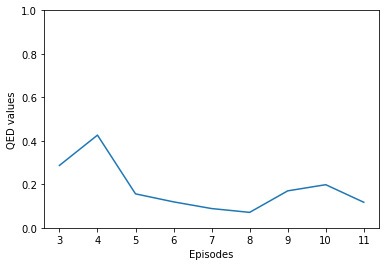

In [59]:
plot_QED(episodes_double, rewards_double)

Now let's import data of models that have been trained for $3000$ eposides. You should notice that the double Q learning beat the DQN by achieving higher QED scores (as high as $0.94$). The full training processes took about 2 hours on GPU clusters or 6 hours on CPU.

In [42]:
def subplot_QED(episodes_dqn, rewards_dqn, episodes_double, rewards_double):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(episodes_dqn, rewards_dqn)
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('QED values')
    ax1.set_title('Deep Q learning')
    ax1.set_ylim([0.0, 1.0])
    
    ax2.plot(episodes_double, rewards_double)
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('QED values')
    ax2.set_title('Double Q learning')
    ax2.set_ylim([0.0, 1.0])
    
    plt.show()

In [43]:
import pickle
with open('DQN_results', 'rb') as f:
    episodes_DQN, smiles_DQN, rewards_DQN, losses_DQN = pickle.load(f)

In [44]:
with open('doubleQ_results', 'rb') as f:
    eposides_DOUBLE, smiles_DOUBLE, rewards_DOUBLE, losses_DOUBLE = pickle.load(f)

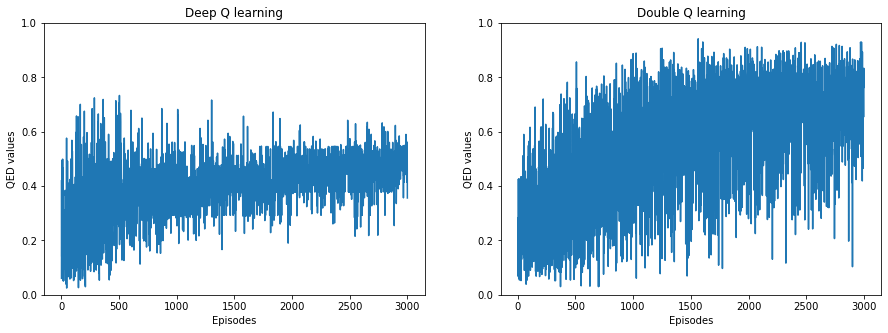

In [45]:
subplot_QED(episodes_DQN, rewards_DQN, eposides_DOUBLE, rewards_DOUBLE)

In [46]:
from rdkit.Chem import Draw
from rdkit.Chem.rdmolfiles import MolFromSmiles as smi2mol
def visulize_mol(smiles):
    ms = []
    for s in smiles:
        ms.append(smi2mol(s))
    fig = Draw.MolsToGridImage(ms)
    return fig

Below are several molecules generated with highest scores from training.

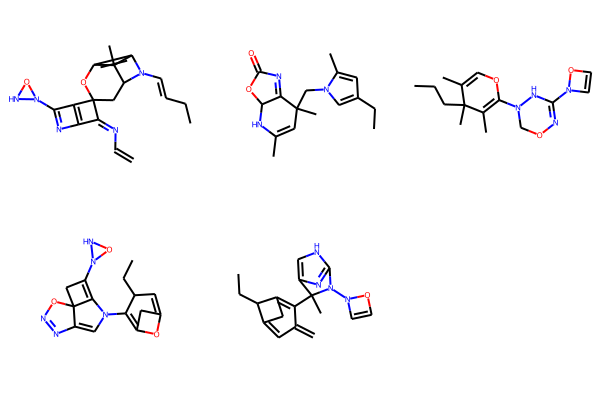

In [50]:
rewards = np.array(rewards_DOUBLE)
idx = rewards.argsort()[-5:]
smiles = []
for i in idx:
    smiles.append(smiles_DOUBLE[i])
fig = visulize_mol(smiles)
fig

In [63]:
# Please set do_training at the begining of this assignment to False. Thank you!
assert do_training == False

Hope you enjoy this assignment. Thank you very much!

**This is the end of the assignment**